# Tutorial: Using NSDF for End-to-End Analysis of Scientific Data

In this tutorial, you will learn how to:

* Build a modular workflow integrating your application module with NSDF services for data visualization and analysis.
* Load and store intermediate data from/to public storage options like Dataverse and from/to private storage such as Seal Storage.
* Use the NSDF dashboard for data visualization and analysis. The analysis includes zooming into data for detailed analysis, cropping subregions, and saving them locally in a Python-compatible format.

### **DISCLAIMER:** Please **DO NOT *Run All Cells*** because different paths can be executed leading to the same outcome

## Tutorial Overview

The workflow in Figure 1 uses a chain of tools and services to showcase the NSDF capabilities for studying a geospatial dataset generated with [GEOtiled](https://github.com/TauferLab/GEOtiled/tree/main)[1] (a module of the [SOMOSPIE](https://github.com/TauferLab/SOMOSPIE) engine [2-3]). The workflow comprises four steps.

**Step 1. Data Generation:** This initial step acquires data from the [United States Geological Survey (USGS)](https://www.usgs.gov/) and processes it with GEOtiled (Option A) or uploads the data from either a public or private storage (Option B).

**Step 2. Conversion to IDX Format:** In this step, TIF files containing geospatial data from the first step are converted into IDX format using OpenVisus. This conversion process results in terrain parameter files that maintain the original accuracy but are more compact in size. These new, optimized files can be stored on either public or private storage solutions.

**Step 3. Static Visualization:** The third stage uses the IDX files within OpenVisus for validating the data conversion and creating a static visualization using OpenVisus.

**Step 4. Interactive Visualization and Analysis:** The last step launches a dashboard that allows users to work on large-scale data, extract and save subregions of the original dataset, and study and extract features. 

Throughout these steps, the workflow incorporates the use of public storage services (e.g., Dataverse, CyVerse) and private storage providers (e.g., Seal Storage, S3 AWS, IBM Cloud Object Storage). These services are connected to the conversion, visualization, and analysis steps, highlighting their crucial role in this tutorial's data processing and transformation steps.


<div>
<center><img src="files/docs/workflow-diagram.png" width="800"/>
</div>
<center><b>Figure 1:</b> Tutorial steps.

## -> Preparing your Environment 

***Note:** Run this cell to import all the necessary dependencies. Select the python kernel **"NSDF-Tutorial"**.* 

The following cell prepares the environment for processing and visualizing geospatial data by importing various crucial libraries for workflow execution. Please note that running this cell might take some time. Upon completion, a message will be displayed to notify you that the cell execution has finished.

In [1]:
import geotiled as gt
from pathlib import Path
import glob
import os
import shutil
import multiprocessing
import OpenVisus as ov
import numpy as np
import requests
import json
from matplotlib import pyplot as plt
from tqdm import tqdm

# To silence a deprecation warning.
gt.gdal.UseExceptions()

# You have have successfully prepared your environment.
print("You have successfully prepared your environment.")

You have successfully prepared your environment.


## -> Step 1. Data Generation

Step 1 provides two options for users to obtain data: Option A allow the users to  downloading raw data from a public archive, such as elevation data from the USGS archive, and then processing it using the user's application, in this instance, the GEOtiled module from the [SOMOSPIE](https://github.com/TauferLab/SOMOSPIE) earth science application. Option B allows users to access data directly from existing public or private storage. In this instance we use existing data stored in [Dataverse](https://dataverse.harvard.edu/) without the need for initial downloading and processing.


###  -- Option A: Generating Data Using the SOMOSPIE Application Module

We use the [SOMOSPIE](https://github.com/TauferLab/SOMOSPIE) application, specifically its GEOtiled module, to generate a high-resolution dataset of terrain parameters. This process involves using Digital Elevation Models (DEMs) from the USGS 3D Elevation Program as input. The GEOtiled module processes this data to produce two key terrain parameters: elevation, and hillshading, all at a 30 m resolution specifically for the state of Tennessee. The output consists of four TIFF format image files, each representing the calculated elevation, and hillshading.

The following cell sets initial paths, variable names and values used in the GEOtiled module.

In [2]:
download_list = "./download_urls.txt"  # Where the list of download links will be stored
root_output_folder = "./files/tif_files/"  # root folder where geotiled will store data
n_tiles = 4  # Number of tiles that are generated for parameter computation
dem_tiles_dir_name = "tiles"  # Folder where downloaded DEM tiles will be saved
param_tiles_dir_name = (
    "elevation_tiles"  # Folder where computation tiles will be saved.
)
gcs_name = "gcs.tif"  # Name for the mosaicked DEM
pcs_name = "pcs.tif"  # Name for the projected DEM
shapefile = ["./files/shape_files/STATEFP_47.shp"]  # Shapefile for Visualization
region_bounding_box = {
    "xmin": -90.4,
    "ymin": 34.8,
    "xmax": -81.55,
    "ymax": 36.8,
}  # For `fetch_dem`. X=Longitude Y=Latitude. Determine bounding coordinates by looking at a map.

print("You have successfully initialized the GEOtiled variables.")

You have successfully initialized the GEOtiled variables.


The following cell fetches the Digital Elevation Models (DEMs) from the USGS archive.

***Note:** Because we are downloading data from USGS, the execution time of this cell depends on your Internet's speed.* 

In [3]:
# Fetching Data
tiles_folder = os.path.join(root_output_folder, dem_tiles_dir_name)
Path(root_output_folder).mkdir(parents=True, exist_ok=True)
Path(tiles_folder).mkdir(parents=True, exist_ok=True)

# Setting up for parameter computation
gcs = os.path.join(root_output_folder, gcs_name)
pcs = os.path.join(root_output_folder, pcs_name)
elevation_tiles = os.path.join(root_output_folder, param_tiles_dir_name)
Path(elevation_tiles).mkdir(parents=True, exist_ok=True)

# Computing Parameters
aspect_tiles = os.path.join(root_output_folder, "aspect_tiles")
hillshading_tiles = os.path.join(root_output_folder, "hillshading_tiles")
slope_tiles = os.path.join(root_output_folder, "slope_tiles")
Path(aspect_tiles).mkdir(parents=True, exist_ok=True)
Path(hillshading_tiles).mkdir(parents=True, exist_ok=True)
Path(slope_tiles).mkdir(parents=True, exist_ok=True)

gt.fetch_dem(
    bbox=region_bounding_box,
    txtPath=download_list,
    dataset="National Elevation Dataset (NED) 1 arc-second Current",
)
gt.download_files(download_list, tiles_folder)

print("You have successfully downloaded the DEMs from USGS.")

./download_urls.txt


Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.72G/1.72G [00:16<00:00, 104MB/s]

You have successfully downloaded the DEMs from USGS.


The following cell deploys GEOtiled to process the downloaded DEMs, build a mosaic, reproject, and crop with buffers from preprocessing. If you would like to learn more about this workflow, please check the [GEOtiled module.](https://github.com/TauferLab/GEOtiled/tree/main)

***Note:** This cell is merging all the DEMs and projecting them with the right coordinate system so it can take up to 5 mins.* 

In [4]:
raster_list = glob.glob(tiles_folder + "/*")

gt.build_mosaic(raster_list, gcs)

shutil.rmtree(tiles_folder)
os.remove("./merged.vrt")

gt.reproject(gcs, pcs, "EPSG:9822")

os.remove(gcs)

gt.crop_into_tiles(pcs, elevation_tiles, n_tiles)

glob_of_tiles = glob.glob(elevation_tiles + "/*.tif")

print("You have successfully processed the DEMs using GEOtiled")

You have successfully processed the DEMs using GEOtiled


The following cell takes the processed DEMs and calculates the other terrain parameter (hillshading). 

***Note:** This cell is compute-heavy because we are calculating the hillshading from the elevation. Therefore, it can take up to 10 mins.* 

In [5]:
pool = multiprocessing.Pool(processes=n_tiles)
pool.map(gt.compute_geotiled, sorted(glob.glob(elevation_tiles + "/*.tif")))

gt.build_mosaic_filtered(
    sorted(glob.glob(aspect_tiles + "/*.tif")),
    os.path.join(root_output_folder, "aspect.tif"),
)
gt.build_mosaic_filtered(
    sorted(glob.glob(hillshading_tiles + "/*.tif")),
    os.path.join(root_output_folder, "hillshading.tif"),
)
gt.build_mosaic_filtered(
    sorted(glob.glob(slope_tiles + "/*.tif")),
    os.path.join(root_output_folder, "slope.tif"),
)
shutil.rmtree(aspect_tiles)
shutil.rmtree(hillshading_tiles)
shutil.rmtree(slope_tiles)
shutil.rmtree(elevation_tiles)

print("You have successfully computed all the terrain parameters.")

RuntimeError: No input dataset specified.

The following cell uses the GEOtiled library to visualize the two terrain parameters: elevation, and hillshading.

***Note:** This cell can take up to 5 mins to visualize the data.* 

In [ ]:
hill = os.path.join(root_output_folder, "hillshading.tif")
aspect = os.path.join(root_output_folder, "aspect.tif")
slope = os.path.join(root_output_folder, "slope.tif")

pcs_array = gt.generate_img(
    pcs,
    downsample=5,
    reproject_gcs=True,
    shp_files=shapefile,
    title="Elevation Data for TN @ 1 Arc-Second/30m Resolution",
    zunit="Meter",
    xyunit="Degree",
    ztype="Elevation",
    crop_shp=True,
)
aspect_array = gt.generate_img(
    aspect,
    downsample=5,
    reproject_gcs=True,
    shp_files=shapefile,
    title="Aspect Data for Rhode TN @ 1 Arc-Second/30m Resolution",
    zunit="Degree",
    xyunit="Degree",
    ztype="Aspect",
    crop_shp=True,
)
hill_array = gt.generate_img(
    hill,
    downsample=5,
    reproject_gcs=True,
    shp_files=shapefile,
    title="Hillshading Data for TN @ 1 Arc-Second/30m Resolution",
    zunit="Level",
    xyunit="Degree",
    ztype="Hillshading",
    crop_shp=True,
)
slope_array = gt.generate_img(
    slope,
    downsample=5,
    reproject_gcs=True,
    shp_files=shapefile,
    title="Slope Data for TN @ 1 Arc-Second/30m Resolution",
    zunit="Degree",
    xyunit="Degree",
    ztype="Slope",
    crop_shp=True,
)
print("You have successfully visualized the 2 terrain parameters using GEOtiled")

### -> Option B. Accessing Data from Dataverse Public Commons

High-resolution data for elevation and hillshading at a 30m resolution for Tennessee might already exist in public storage repositories. If available, you can directly download this data to proceed to Step 2 without the need for initial data generation.

The following cell establishes a connection with a public storage service such as Dataverse and downloads previously generated TIFF files.

***Note:** Because we are downloading data from Dataverse, the execution time of this cell depends on your Internet's speed.* 

In [6]:
if not os.path.exists("files/tif_files"):
    os.mkdir("files/tif_files")

with open("./files/json/dataverse.json", "r") as file:
    urls = json.load(file)


def get_data_from_dataverse(data):
    file_url = data.get("url")
    name_file = data.get("name_file")
    resp = requests.get(file_url)
    with open(name_file, "wb") as f:
        f.write(resp.content)


print("Your download is starting...")

pool = multiprocessing.Pool(processes=len(urls))
pool.map(get_data_from_dataverse, urls)


print("You have successfully downloaded the data from Dataverse.")

Your download is starting...
You have successfully downloaded the data from Dataverse.


The following cell uses the GEOtiled library to verify the download step and visualize the two terrain parameters: elevation, and hillshading. 
***Note:** This cell can take up to 5 mins to visualize the data.* 

Reprojecting..
Cropping with combined shapefiles...
Done.
Reading in tif for visualization...
Done.
Plotting data...
Done. (image should appear soon...)
Reprojecting..
Cropping with combined shapefiles...
Done.
Reading in tif for visualization...
Done.
Plotting data...
Done. (image should appear soon...)
Reprojecting..
Cropping with combined shapefiles...
Done.
Reading in tif for visualization...
Done.
Plotting data...
Done. (image should appear soon...)
Reprojecting..
Cropping with combined shapefiles...
Done.
Reading in tif for visualization...
Done.
Plotting data...
Done. (image should appear soon...)
You have successfully visualized the data from Dataverse.


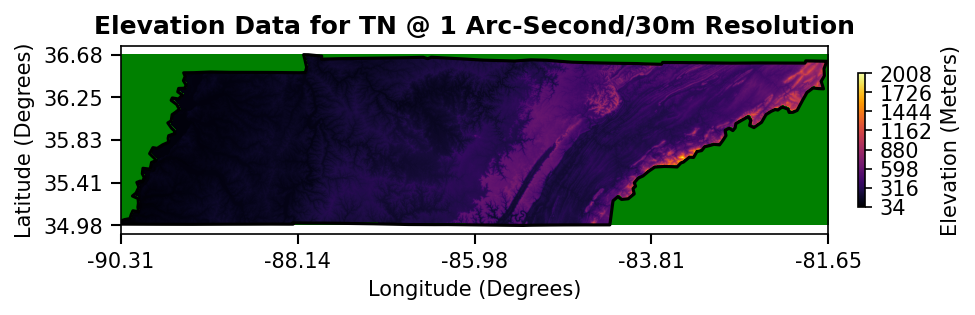

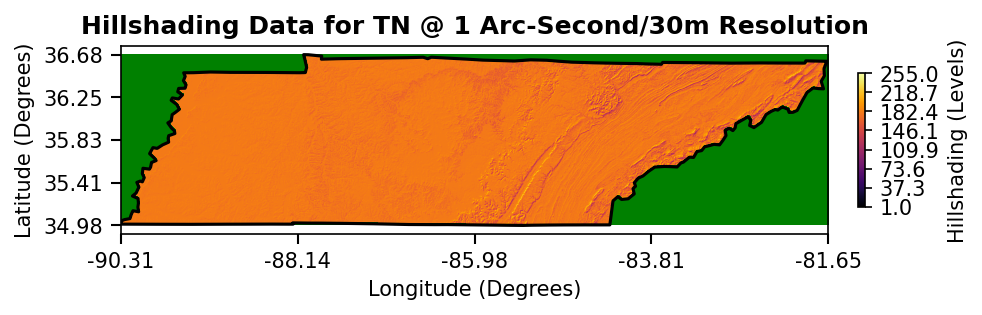

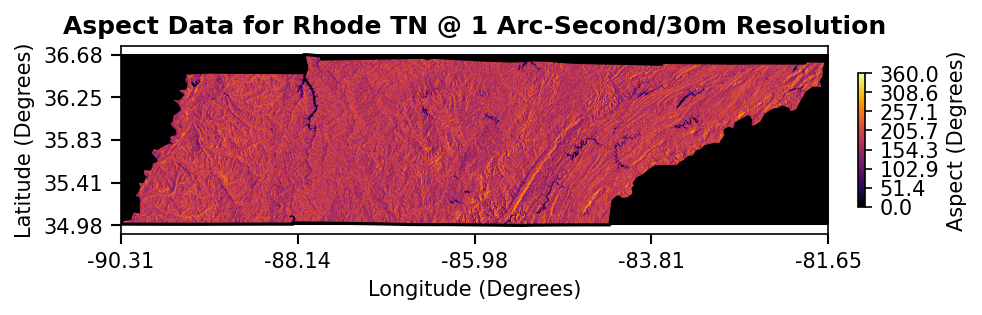

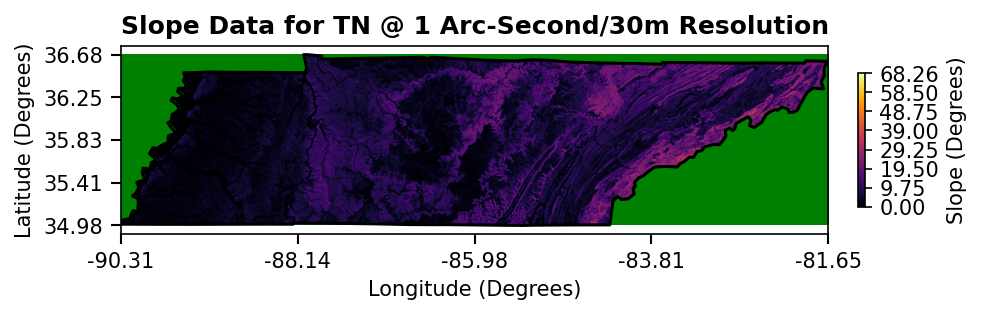

In [7]:
shapefile = ["./files/shape_files/STATEFP_47.shp"]  # Shapefile for Visualization
hill = os.path.join("./files/tif_files/", "hillshading.tif")
pcs = os.path.join("./files/tif_files/", "elevation.tif")
aspect = os.path.join("./files/tif_files/", "aspect.tif")
slope = os.path.join("./files/tif_files/", "slope.tif")
pcs_array = gt.generate_img(
    pcs,
    downsample=5,
    reproject_gcs=True,
    shp_files=shapefile,
    title="Elevation Data for TN @ 1 Arc-Second/30m Resolution",
    zunit="Meter",
    xyunit="Degree",
    ztype="Elevation",
    crop_shp=True,
)
hill_array = gt.generate_img(
    hill,
    downsample=5,
    reproject_gcs=True,
    shp_files=shapefile,
    title="Hillshading Data for TN @ 1 Arc-Second/30m Resolution",
    zunit="Level",
    xyunit="Degree",
    ztype="Hillshading",
    crop_shp=True,
)
aspect_array = gt.generate_img(
    aspect,
    downsample=5,
    reproject_gcs=True,
    shp_files=shapefile,
    title="Aspect Data for Rhode TN @ 1 Arc-Second/30m Resolution",
    zunit="Degree",
    xyunit="Degree",
    ztype="Aspect",
    crop_shp=True,
)
slope_array = gt.generate_img(
    slope,
    downsample=5,
    reproject_gcs=True,
    shp_files=shapefile,
    title="Slope Data for TN @ 1 Arc-Second/30m Resolution",
    zunit="Degree",
    xyunit="Degree",
    ztype="Slope",
    crop_shp=True,
)
print("You have successfully visualized the data from Dataverse.")

**_Important:_** The two images created by the GEOtiled module are high-resolution, large, and static. They do not allow users to manipulate the embedded information, including zooming into subregions, cropping them, and saving the cropped areas either locally or on other platforms for further analysis. Additionally, these images are provided in the TIFF format, which results in large file sizes.

## -> Step 2: Converting to IDX Format

After generating the data, it needs to be converted into the IDX format to be compatible with OpenVisus. This process involves creating a single IDX file that includes all the terrain parameters as distinct fields.

***Note:** Completing one of the data generation options in Step 1 is a prerequisite for proceeding with this step.*

The following cell extracts the geospatial metadata from one of the terrain parameters, in this case hillshading. This geospatial metadata provides reference to the coordinates and projection system. 

In [8]:
# Generate lat/lon min/max from tiff
from osgeo import gdal, osr

hill = os.path.join("./files/tif_files/", "hillshading.tif")

dataset = gdal.Open(hill)
band = dataset.GetRasterBand(1)

geotransform = dataset.GetGeoTransform()
spatial_ref = osr.SpatialReference(wkt=dataset.GetProjection())

target_spatial_ref = osr.SpatialReference()
target_spatial_ref.ImportFromEPSG(4326)

coord_transform = osr.CoordinateTransformation(spatial_ref, target_spatial_ref)
ulx, xres, _, uly, _, yres = geotransform
lrx = ulx + (dataset.RasterXSize * xres)
lry = uly + (dataset.RasterYSize * yres)
top_left_geo = coord_transform.TransformPoint(ulx, uly)
bottom_right_geo = coord_transform.TransformPoint(lrx, lry)

lon_1, lat_1, _ = top_left_geo
lon_2, lat_2, _ = bottom_right_geo
lat_min = min(lat_1, lat_2)
lat_max = max(lat_1, lat_2)
lon_min = min(lon_1, lon_2)
lon_max = max(lon_1, lon_2)

print(f"Longitude range: {lat_min} to {lat_max}")
print(f"Latitude range: {lon_min} to {lon_max}")

print("You have successfully extract geospatial metadata from the TIFFs.")

Longitude range: -90.13101550084446 to -82.07752877171617
Latitude range: 34.302222511744404 to 37.325468259540294
You have successfully extract geospatial metadata from the TIFFs.


The following cell takes the four terrain parameters and assign each to a different Field. `Fields` should be in this format: `[ov.Field(FIELD_NAME, DTYPE)]`. After the creation of the IDX, this one is compressed. 

In [9]:
filename = "idx_data/Tennessee_terrain_parameters.idx"
all_fields = [
    ov.Field("elevation", "float32"),
    ov.Field("hillshading", "uint8"),
    ov.Field("aspect", "float32"),
    ov.Field("slope", "float32"),
]
input_data = [
    np.flipud(pcs_array).copy(),
    np.flipud(hill_array).copy(),
    np.flipud(aspect_array).copy(),
    np.flipud(slope_array).copy(),
]
height, width = input_data[0].shape
db = ov.CreateIdx(
    url=filename,
    dims=[width, height],
    fields=all_fields,
    arco="4mb",
    physic_box=ov.BoxNd.fromString(f"{lat_min} {lat_max} {lon_min} {lon_max}"),
    time=[0, 0, "%00000d/"],
)
i = 0
for fld in db.getFields():
    db.write(input_data[i], field=fld)
    i += 1
db.compressDataset(["zip"])

print("You have successfully created the IDX file with the four terrain parmaters.")

You have successfully created the IDX file with the two terrain parmaters.


## -> Step 3: Static Visualization

After the data has been generated, transformed into the correct format, and compressed, we proceed to validate the data by using Openvisus to visualize it. For this validation step, you can have data locally (Option A) or grab the IDX files previously stored from remote storage (Option B). For this specific example, we are using Seal Storage.  

### -> Option A: Loading the Dataset from Local Storage

This option involves importing the dataset into the dashboard directly from local storage contained within the Docker image.

The following cell loads the dataset in IDX format from a local file

In [11]:
filename = "idx_data/Tennessee_terrain_parameters.idx"
db = ov.LoadDataset(filename)
print("You have successfully loaded the IDX file with the four terrain parmaters.")

You have successfully loaded the IDX file with the two terrain parmaters.


The followitng cell takes the loaded IDX files with Openvisus and statically visualizes it. 

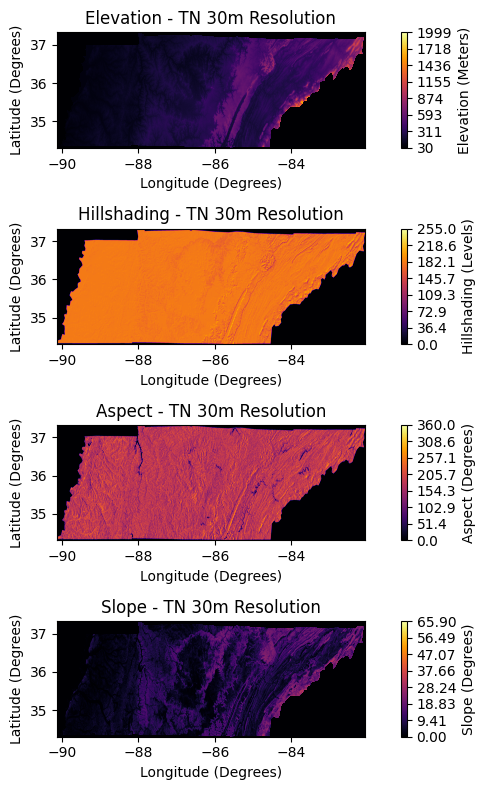

You have successfully visualized the IDX files.


In [12]:
read_elevation = db.read(field="elevation")
read_hillshading = db.read(field="hillshading")
read_aspect = db.read(field="aspect")
read_slope = db.read(field="slope")

cmap_instance = plt.get_cmap("inferno")

fig, axs = plt.subplots(4, 1, figsize=(10, 8))
axs[0].set_xlim(lat_min, lat_max)
axs[0].set_ylim(lon_min, lon_max)
axs[0].set_title("Elevation - TN 30m Resolution")
axs[0].set_xlabel("Longitude (Degrees)")
axs[0].set_ylabel("Latitude (Degrees)")
elevation_fig = axs[0].imshow(
    read_elevation,
    cmap=cmap_instance,
    origin="lower",
    vmin=30,
    vmax=1999,
    extent=(lat_min, lat_max, lon_min, lon_max),
)

cbar = fig.colorbar(
    elevation_fig,
    fraction=0.046 * read_elevation.shape[0] / read_elevation.shape[1],
    pad=0.04,
)
cbar_ticks = np.linspace(30, 1999, 8)
cbar.set_ticks(cbar_ticks)
cbar.set_label("Elevation (Meters)")

axs[1].set_xlim(lat_min, lat_max)
axs[1].set_ylim(lon_min, lon_max)
axs[1].set_title("Hillshading - TN 30m Resolution")
axs[1].set_xlabel("Longitude (Degrees)")
axs[1].set_ylabel("Latitude (Degrees)")
hillshading_fig = axs[1].imshow(
    read_hillshading,
    cmap=cmap_instance,
    origin="lower",
    vmin=0,
    vmax=255,
    extent=(lat_min, lat_max, lon_min, lon_max),
)

cbar = fig.colorbar(
    hillshading_fig,
    fraction=0.046 * read_hillshading.shape[0] / read_hillshading.shape[1],
    pad=0.04,
)
cbar_ticks = np.linspace(0, 255, 8)
cbar.set_ticks(cbar_ticks)
cbar.set_label("Hillshading (Levels)")

axs[2].set_xlim(lat_min, lat_max)
axs[3].set_ylim(lon_min, lon_max)
axs[2].set_title("Aspect - TN 30m Resolution")
axs[2].set_xlabel("Longitude (Degrees)")
axs[2].set_ylabel("Latitude (Degrees)")
aspect_fig = axs[2].imshow(
    read_aspect,
    cmap=cmap_instance,
    vmin=0,
    origin="lower",
    vmax=360,
    extent=(lat_min, lat_max, lon_min, lon_max),
)


cbar = fig.colorbar(
    aspect_fig, fraction=0.046 * read_aspect.shape[0] / read_aspect.shape[1], pad=0.04
)
cbar_ticks = np.linspace(0, 360, 8)
cbar.set_ticks(cbar_ticks)
cbar.set_label("Aspect (Degrees)")

axs[3].set_xlim(lat_min, lat_max)
axs[3].set_ylim(lon_min, lon_max)
axs[3].set_title("Slope - TN 30m Resolution")
axs[3].set_xlabel("Longitude (Degrees)")
axs[3].set_ylabel("Latitude (Degrees)")
slope_fig = axs[3].imshow(
    read_slope,
    cmap=cmap_instance,
    vmin=0,
    origin="lower",
    vmax=65.9,
    extent=(lat_min, lat_max, lon_min, lon_max),
)


cbar = fig.colorbar(
    slope_fig, fraction=0.046 * read_slope.shape[0] / read_slope.shape[1], pad=0.04
)
cbar_ticks = np.linspace(0, 65.9, 8)
cbar.set_ticks(cbar_ticks)
cbar.set_label("Slope (Degrees)")

plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.tight_layout()


plt.show()
print("You have successfully visualized the IDX files.")

**_Important:_** These images are the visualization of the IDX compressed dataset for the four terrain parameters. They serve as validation for the conversion from TIFF to IDX, ensuring the reduction in the size of the data without losing the accuracy. However, this visualization does not allow users to manipulate the embedded information, including zooming into subregions, cropping them, and saving the cropped areas either locally or on other platforms for further analysis.

### -> Option B: Loading the Dataset from Seal Storage

For this option, the IDX dataset is uploaded into the dashboard from a private archive that has been previously generated and stored in Seal Storage.

The following cell establishes a connection with a private storage service such as Seal Storage and downloads previously generated IDX files.

In [13]:
filename = "Tennessee_terrain_parameters.idx"
HOME_DIR = "s3://utah/nsdf/somospie/"  # DONOT change this line
data_dir = "terrain_tennessee/"
upload_dir = HOME_DIR + data_dir
s3_path = upload_dir.split("://")[1]
s3_path += filename
remote_dir = (
    "https://maritime.sealstorage.io/api/v0/s3/"
    + s3_path
    + "?access_key=any&secret_key=any&endpoint_url=https://maritime.sealstorage.io/api/v0/s3&cached=arco"
)

db = ov.LoadDataset(remote_dir)

print("You have successfully downloaded the IDX files from Seal Storage.")

You have successfully downloaded the IDX files from Seal Storage.


The followitng cell takes the loaded IDX files with Openvisus and statically visualizes it. 

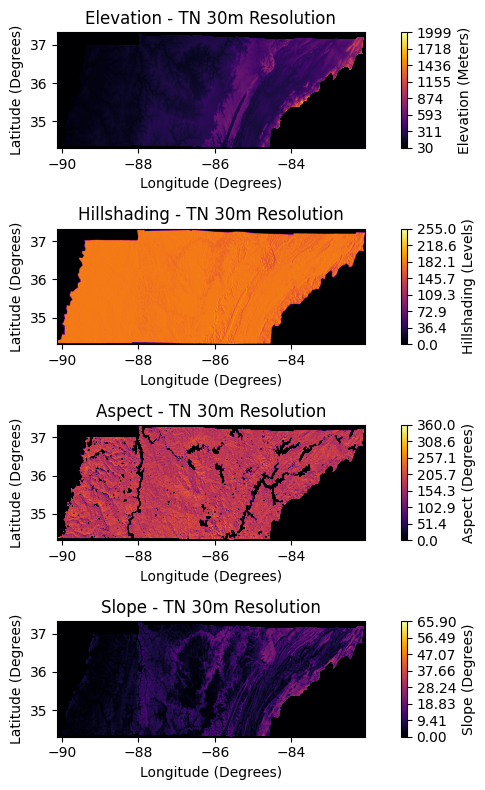

You have successfully visualized the IDX files.


In [14]:
read_elevation = db.read(field="elevation")
read_hillshading = db.read(field="hillshading")
read_aspect = db.read(field="aspect")
read_slope = db.read(field="slope")

cmap_instance = plt.get_cmap("inferno")

fig, axs = plt.subplots(4, 1, figsize=(10, 8))
axs[0].set_xlim(lat_min, lat_max)
axs[0].set_ylim(lon_min, lon_max)
axs[0].set_title("Elevation - TN 30m Resolution")
axs[0].set_xlabel("Longitude (Degrees)")
axs[0].set_ylabel("Latitude (Degrees)")
elevation_fig = axs[0].imshow(
    read_elevation,
    cmap=cmap_instance,
    origin="lower",
    vmin=30,
    vmax=1999,
    extent=(lat_min, lat_max, lon_min, lon_max),
)

cbar = fig.colorbar(
    elevation_fig,
    fraction=0.046 * read_elevation.shape[0] / read_elevation.shape[1],
    pad=0.04,
)
cbar_ticks = np.linspace(30, 1999, 8)
cbar.set_ticks(cbar_ticks)
cbar.set_label("Elevation (Meters)")

axs[1].set_xlim(lat_min, lat_max)
axs[1].set_ylim(lon_min, lon_max)
axs[1].set_title("Hillshading - TN 30m Resolution")
axs[1].set_xlabel("Longitude (Degrees)")
axs[1].set_ylabel("Latitude (Degrees)")
hillshading_fig = axs[1].imshow(
    read_hillshading,
    cmap=cmap_instance,
    origin="lower",
    vmin=0,
    vmax=255,
    extent=(lat_min, lat_max, lon_min, lon_max),
)

cbar = fig.colorbar(
    hillshading_fig,
    fraction=0.046 * read_hillshading.shape[0] / read_hillshading.shape[1],
    pad=0.04,
)
cbar_ticks = np.linspace(0, 255, 8)
cbar.set_ticks(cbar_ticks)
cbar.set_label("Hillshading (Levels)")

axs[2].set_xlim(lat_min, lat_max)
axs[3].set_ylim(lon_min, lon_max)
axs[2].set_title("Aspect - TN 30m Resolution")
axs[2].set_xlabel("Longitude (Degrees)")
axs[2].set_ylabel("Latitude (Degrees)")
aspect_fig = axs[2].imshow(
    read_aspect,
    cmap=cmap_instance,
    vmin=0,
    origin="lower",
    vmax=360,
    extent=(lat_min, lat_max, lon_min, lon_max),
)


cbar = fig.colorbar(
    aspect_fig, fraction=0.046 * read_aspect.shape[0] / read_aspect.shape[1], pad=0.04
)
cbar_ticks = np.linspace(0, 360, 8)
cbar.set_ticks(cbar_ticks)
cbar.set_label("Aspect (Degrees)")

axs[3].set_xlim(lat_min, lat_max)
axs[3].set_ylim(lon_min, lon_max)
axs[3].set_title("Slope - TN 30m Resolution")
axs[3].set_xlabel("Longitude (Degrees)")
axs[3].set_ylabel("Latitude (Degrees)")
slope_fig = axs[3].imshow(
    read_slope,
    cmap=cmap_instance,
    vmin=0,
    origin="lower",
    vmax=65.9,
    extent=(lat_min, lat_max, lon_min, lon_max),
)


cbar = fig.colorbar(
    slope_fig, fraction=0.046 * read_slope.shape[0] / read_slope.shape[1], pad=0.04
)
cbar_ticks = np.linspace(0, 65.9, 8)
cbar.set_ticks(cbar_ticks)
cbar.set_label("Slope (Degrees)")

plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.tight_layout()


plt.show()

print("You have successfully visualized the IDX files.")

## -> Step 4: Interactive Visualization and Analysis of Geospatial Data Using the NSDF Dashboard 

After validating the correct conversion from TIFF to IDX and visualizing statically the data. We create a dashboard that enables scientists to interact, visualize, and analyze geospatial data. You can zoom into data for detailed analysis, cropping subregions, and saving them locally in a Python-compatible format. For this step, you can have data locally (Option A) or grab the IDX files previously stored from remote storage (Option B). 

We present two geographical regions. The first region is for the state of Tennessee for consistency of the tutorial. However, we want to go beyond and show the power of interacting with a large geospatial dataset that may not fit in your local computer, for example, the Contiguous United States at 30 m resolution. 

***Note: When running multiple regions make sure to stop and run one dashboard launching cell at the time***

This cell configures the Port and Address settings.

In [15]:
PORT = "8989"  # Dont change this since this is the forwarded port.
ADDRESS = "0.0.0.0"  # Local to the server; 0.0.0.0 or 127.0.0.1

print("You have successfully set the port for the dashboard.")

You have successfully set the port for the dashboard.


### -> Geographical Region: Tennessee
For the first data scenario, you can interact with geospatial data in IDX format from Tennessee. You can load from local storage (Option A) or from remote storage (Option B).  

#### -> Option A. Load dataset from a local storage

This cell uploads data from local storage to input in the dashboard.

In [16]:
URL = "idx_data/Tennessee_terrain_parameters.idx"

print("You have successfully loaded local IDX data for Tennessee.")

You have successfully loaded local IDX data for Tennessee.


In [17]:
%%capture
## Stop this cell before running another visualization dashboard
!python -m panel serve openvisuspy/src/openvisuspy/dashboards --log-file "files/log.log" --dev --allow-websocket-origin='*' --address="{ADDRESS}" --port "{PORT}" --args "{URL}" 

##### Visit http://localhost:8989 to explore the dashboard

#### Option B. Load dataset from Seal Storage

This cell uploads data from a Seal Storage as input in the dashboard. 

In [ ]:
URL = "https://maritime.sealstorage.io/api/v0/s3/utah/nsdf/somospie/tennessee_30m_terrain/Tennessee_terrain_parameters.idx?access_key=any&secret_key=any&endpoint_url=https://maritime.sealstorage.io/api/v0/s3&cached=arco"
print("You have successfully loaded the IDX Tennessee data from remote storage.")

This cell executes the dashboard, enabling us to zoom into specific subregions of the state of Tennessee and examine the terrain parameter patterns.

In [ ]:
%%capture
## Stop this cell before running another visualization dashboard
!python -m panel serve openvisuspy/src/openvisuspy/dashboards --log-file "files/log.log" --dev --allow-websocket-origin='*' --address="{ADDRESS}" --port "{PORT}" --args "{URL}"

##### Visit http://localhost:8989 to explore the dashboard

### -> Geographical Region: Contiguous United States

For the second data scenario, you can interact with geospatial data in IDX format from the Contiguous United States without storing this large dataset locally. The dashboard directly streams the data from remote storage, in this case, Seal Storage. You can interact with the data through the NSDF dashboard, zoom in, and select specific subregions of interest to download on your local machine. 

In [18]:
URL = "https://maritime.sealstorage.io/api/v0/s3/utah/nsdf/somospie/conus_30m_terrain/CONUS_30m_Terrain_Parameters.idx?access_key=any&secret_key=any&endpoint_url=https://maritime.sealstorage.io/api/v0/s3&cached=arco"

print("You have successfully loaded the IDX CONUS data from remote storage.")

You have successfully loaded the IDX CONUS data from remote storage.


In [19]:
%%capture
## Stop this cell before running another visualization dashboard
!python -m panel serve openvisuspy/src/openvisuspy/dashboards --log-file "files/log.log" --dev --allow-websocket-origin='*' --address="{ADDRESS}" --port "{PORT}" --args "{URL}"

##### Visit http://localhost:8989 to explore the dashboard

## Learn More About SOMOSPIE and GEOtiled
[1] Roa, C., Olaya, P., Llamas, R., Vargas, R., Taufer, M. GEOtiled: A Scalable Workflow for Generating Large Datasets of High-Resolution Terrain Parameters. Proceedings of the 32nd International Symposium on High-Performance Parallel and Distributed Computing (2023). [link](https://dl.acm.org/doi/abs/10.1145/3588195.3595941)

[2] Olaya, P., Luettgau, J., Roa, C., Llamas, R., Vargas, R., Wen, S., Chung, I., Seelam, S., Park, Y., Lofstead, J., and Taufer, M. Enabling Scalability in the Cloud for Scientific Workflows: An Earth Science Use Case. IEEE International Conference on Cloud Computing (2023). [link](https://research.ibm.com/publications/enabling-scalability-in-the-cloud-for-scientific-workflows-an-earth-science-use-case)

[3] Rorabaugh, D., Guevara, M., Llamas, R., Kitson, J., Vargas, R., and Taufer, M. SOMOSPIE: A modular SOil MOisture SPatial Inference Engine based on data-driven decisions. In Proceedings of the 2019 15th International Conference on eScience (eScience) (2019). [link](https://ieeexplore.ieee.org/document/9041768)

## Learn More About Openvisus
[4] V. Pascucci and R. J. Frank, "Global Static Indexing for Real-Time Exploration of Very Large Regular Grids," SC '01: Proceedings of the 2001 ACM/IEEE Conference on Supercomputing, Denver, CO, USA, 2001, pp. 45-45, [link](http://doi.org/10.1145/582034.582036)

[5] Pascucci, Valerio, et al. "The ViSUS visualization framework." High Performance Visualization. Chapman and Hall/CRC, 2012. 439-452. [link](https://www.taylorfrancis.com/chapters/edit/10.1201/b12985-32/visus-visualization-frame[…]a-gyulassy-cameron-christensen-sujin-philip-sidharth-kumar)

[6] Brian Summa, Giorgio Scorzelli, Ming Jiang, Peer-Timo Bremer, and Valerio Pascucci. 2011. Interactive editing of massive imagery made simple: Turning Atlanta into Atlantis. ACM Trans. Graph. 30, 2, Article 7 (April 2011), 13 pages. [link](https://doi.org/10.1145/1944846.1944847)

## Contact Us

Please, contact us through the [NSDF team](https://nationalsciencedatafabric.org/contributors.html)'s email info@nationalsciencedatafabric.org or directly to the [SOMOSPIE](https://globalcomputing.group/somospie/) PIs, Dr. Michela Taufer mtaufer@utk.edu and Rodrigo Vargas.

## Acknowledgment
The authors of this tutorial would like to express their gratitude to:

* NSF through the awards 2138811, 2103845, 2334945, and 2331152.
* The Dataverse team [link](https://dataverse.org/about)
* The Seal Storage team [link](https://www.sealstorage.io/home/#team)
* Vargas Lab led by Dr. Rodrigo Vargas [link](https://www.udel.edu/academics/colleges/canr/departments/plant-and-soil-sciences/faculty-staff/rodrigo-vargas/)


<div>
<center>
<img src="files/docs/Logos.png" width="450"/>
</div>
<center>